In [1]:
# Code to roduce figure 1 of Amundsen Sea manuscript

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38123/status,
Dashboard: /proxy/38123/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44037,Workers: 0
Dashboard: /proxy/38123/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46445,Total threads: 1
Dashboard: /proxy/43307/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:37103,


In [3]:
# This one is probably the most important function. Could check if it can be simplified and / or if there is a function available in a module that does the same. 

def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [4]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries ...???
    ## Calculates effective sample size using lag1-autocorrelations (Kial Stewart)
    ## Also, finds sampe size by a second method thanks to Josue
    
    n = len(y1)
    nc = int(n/3.5) #end effects? I don't understand this line.
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = scipy.stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = scipy.stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = scipy.stats.pearsonr(x1t, x2t)
    
    #Josue's alternate Neff method
    idx = np.arange(1,nc)
    sni = np.sum((1 - idx/nc) * cor[idx])
    n_star = 1 + 2 * sni
    Neff2 = n/n_star

    return cor, sig, Neff, Neff2

In [8]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [10]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [11]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15
u = exp_ds.search(variable=['u'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['u'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
v=exp_ds.search(variable=['v'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['v'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
taux = exp_ds.search(variable=['tau_x'],frequency='1mon').to_dask()['tau_x'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15
u_ext = ext_ds.search(variable=['u'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['u'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
v_ext = ext_ds.search(variable=['v'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['v'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
taux_ext = ext_ds.search(variable=['tau_x'],frequency='1mon').to_dask()['tau_x'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))

In [ ]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
u_full = xr.concat((u,u_ext),dim='time')
v_full = xr.concat((v,v_ext),dim='time')
taux_full = xr.concat((taux,taux_ext),dim='time')

# Calculate annual
u_an = u_full.resample({'time':'Y'}).mean('time').load()
u_climatology = u_an.mean('time')
v_an = v_full.resample({'time':'Y'}).mean('time').load()
v_climatology = v_an.mean('time')
t_an = temp_full.resample({'time':'Y'}).mean('time').load()
t_climatology = t_an.mean('time')
taux_an = taux_full.resample({'time':'Y'}).mean('time').load()

In [ ]:
# load neutral density
gamma_xr = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_gamma_as_8401_2312.nc')['gamma']
gamma_an = gamma_xr.resample({'time':'Y'}).mean()

In [ ]:
# Load HVE and WMP
# Load WMP on gamma:
wmp_gamma = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_wmp_gamma_on_stocean.nc')['WMP']
hve_gamma = temp_full-temp_full.mean('time')-wmp_gamma

wmp_gamma_an = wmp_gamma.resample({'time':'Y'}).mean()
hve_gamma_an = t_an-t_an.mean('time')-wmp_gamma_an

In [ ]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
#st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [ ]:
# Calculate layer thickness on u cells
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean': 'st_ocean'}))
thickness_u = thickness_u.fillna(0)

In [ ]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

In [ ]:
# Plot parametres: define projection and boundary path, landmask
#xt_ocean = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['xt_ocean'].load()
#yt_ocean = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['yt_ocean'].load()
#xt_ocean = cc.querying.getvar('01deg_jra55v140_iaf_cycle4','xt_ocean',session, n=-1)#.sel(yu_ocean=latrange).sel(xu_ocean = lonrange)
#yt_ocean = cc.querying.getvar('01deg_jra55v140_iaf_cycle4','yt_ocean',session, n=-1)#.sel(yu_ocean=latrange).sel(xu_ocean = lonrange)
# Load them with intake
#xt_ocean = exp_ds.search(variable='xt_ocean',frequency='fx').to_dask()['xt_ocean'].sel(xt_ocean=slice(-150,-50))
#yt_ocean = exp_ds.search(variable='yt_ocean',frequency='fx').to_dask()['yt_ocean'].sel(yt_ocean=slice(-80,-60))

xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen
midlon = -107.5
maxlon = -96.5
minlon = -118.5
minlat = -75.609
maxlat = -69.99
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibl = make_boundary_path(lons, lats)
extent_pibl = [minlon,maxlon,minlat,maxlat]
projection_pibl = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Eastern Amundsen for HVE-WMP
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibm = make_boundary_path(lons, lats)
extent_pibm = [minlon,maxlon,minlat,maxlat]
projection_pibm = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# PIB small
midlon = -105
maxlon = -98
minlon = -112
minlat = -75.8
maxlat = -72
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibs = make_boundary_path(lons, lats)
extent_pibs = [minlon,maxlon,minlat,maxlat]
projection_pibs = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# AS
midlon = -105
maxlon = -80
minlon = -130
minlat = -76
maxlat = -65
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_as = make_boundary_path(lons, lats)
extent_as = [minlon,maxlon,minlat,maxlat]
projection_as = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# West Antarctica
midlon = -105
maxlon = -70
minlon = -140
minlat = -76
maxlat = -64
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)




land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [ ]:
# Perform necessary calculaations: 
# Load 200-400m averages:
t_clims = t_climatology.sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')#.load()
u_clims = u_climatology.sel(st_ocean = slice(100,400)).weighted(thickness_u).mean('st_ocean')#.load()
v_clims = v_climatology.sel(st_ocean = slice(100,400)).weighted(thickness_u).mean('st_ocean')#.load()

# Define section from shelf break to PIG
sla2 = xr.DataArray(np.linspace(-71.1,-75.1, 91))
slo2 = xr.DataArray(np.linspace(-114.5,-101.2,91))
t_sec_asb = t_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
rho_sec_asb = gamma_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
hve_sec_asb = hve_gamma_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
wmp_sec_asb = wmp_gamma_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()

# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

# Calculate time series
taux_as = taux_full.sel(xu_ocean = slice(-120,-90)).sel(yu_ocean = slice(-75.6,-68)).weighted(area_u).mean({'xu_ocean','yu_ocean'}).resample({'time':'Y'}).mean('time').load()
ts_pibsa = (t_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
hve_pibsa = (hve_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
wmp_pibsa = (wmp_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()

In [ ]:
# Calculate Ekman pumping
# use dyu from above, because otherwise the nans from land spread:
phi = 7.292e-5     # Earth's rotation rate; in radians/s
Rearth = 6371e3  # Earth's radius; in m
f = 2 * phi * np.sin(np.deg2rad(dyu.yu_ocean)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=1))
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))

# fill land with zeros:
tauy_f = tauy_full/f
tauy_f = tauy_f.fillna(0)
taux_f = taux_full/f
taux_f = taux_f.fillna(0)

# compute derivatives: Make sure the axes are correct...
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf#.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_man = curl_tauf/rho0*s_day

# mask land:
#ekman= ekman.where(ekman!=0)
#ekmanc= ekmanc.where(ekmanc!=0)

ekman_man_an = ekman_man.resample({'time':'Y'}).mean('time')


#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3]


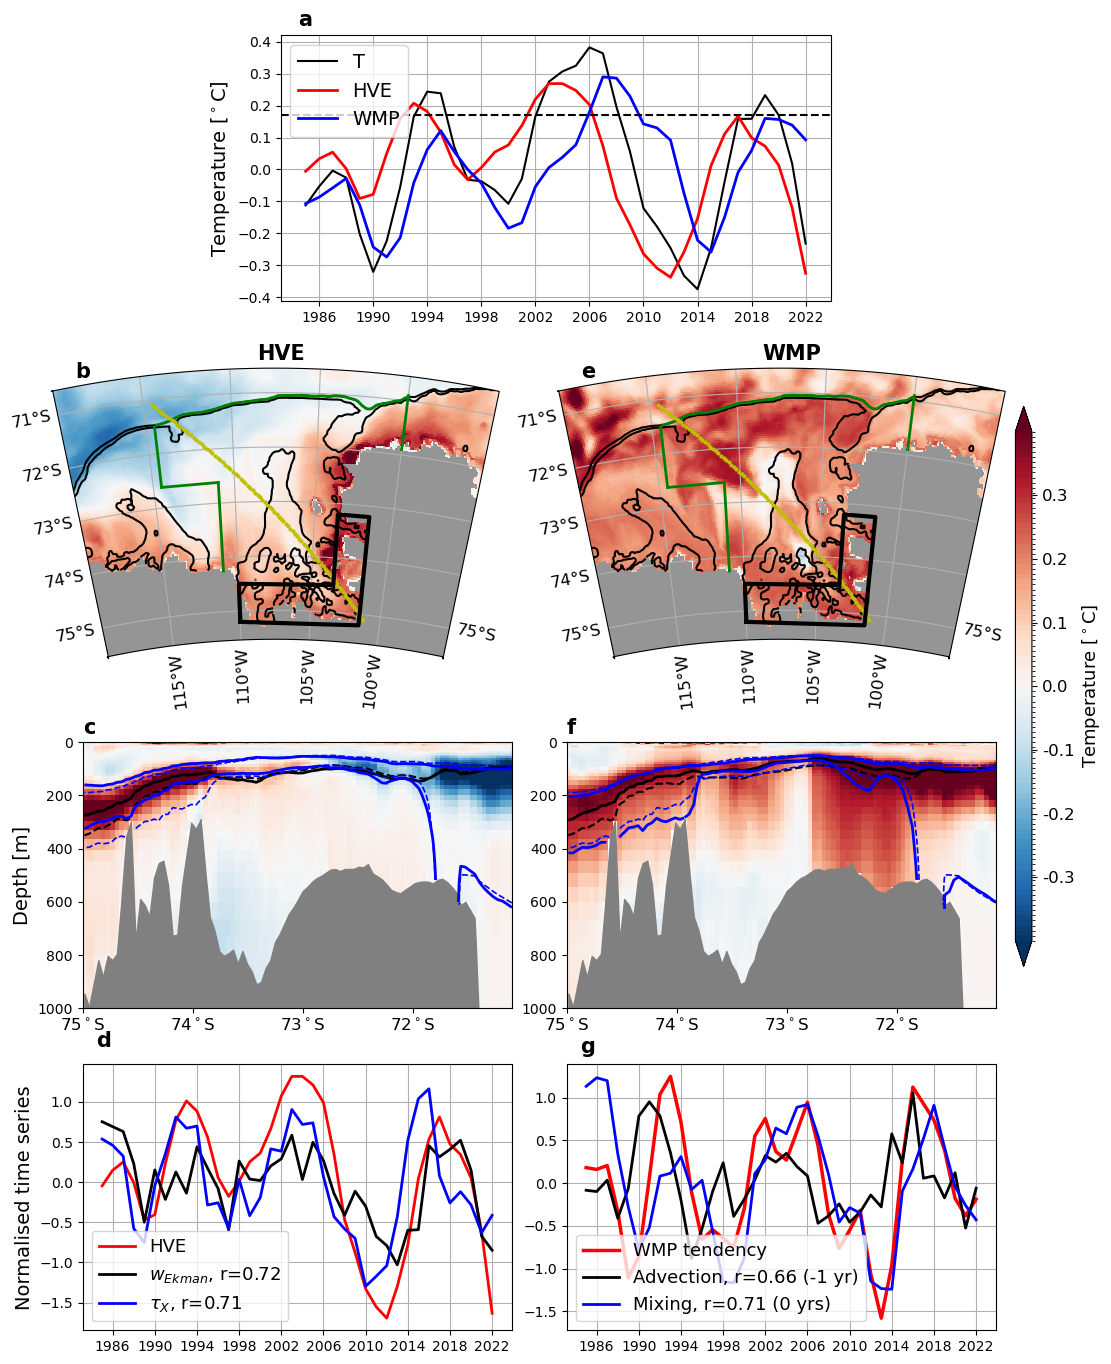

In [73]:
# Comparison of patterns of HVE and spice
compo_thres = 0.17 # (0.12, 0.175) previously used, std
deptu = 250
cvect = np.linspace(-0.4,0.4,101)
fig = plt.figure(figsize=(11,14))
# Define axes
axa = plt.axes([0.25,0.775,0.5,0.19]) # Time series 
ax1 = plt.axes([0.04,0.46,0.41,0.31],projection=projection_pibm) # Map of HVE
ax2 = plt.axes([0.07,0.27,0.39,0.19]) # section HVE
ax3 = plt.axes([0.5,0.46,0.41,0.31],projection=projection_pibm) # Map of WMP
ax4 = plt.axes([0.51,0.27,0.39,0.19]) # section WMP
axin = plt.axes([0.918,0.3,0.015,0.4]) # colorbar Temp
# the following are uncertain still
ax5 = plt.axes([0.07,0.04,0.39,0.19]) # time series for HVE
ax6 = plt.axes([0.51,0.04,0.39,0.19]) # time series for WMP

# Module: HVE-WMP decomposition
#axe = axa.twinx()
(ts_pibsa-ts_pibsa.mean('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean('time').plot(ax=axa,color='k',label='T')
(hve_pibsa).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean('time').plot(ax=axa, color='r', lw=2, label='HVE')
(wmp_pibsa).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean('time').plot(ax=axa,color='b', lw=2, label='WMP')
#p3, = axe.plot(taux_as.time,100*(taux_as).rolling(time=3, center=True).mean(),color='y', lw=3,label=r'$\tau_X')
axa.axhline([compo_thres],color='k',ls='--')
#ax2.legend(fontsize=11)
axa.grid()
axa.set_xlabel('', fontsize=14)
axa.set_ylabel('Temperature [$^\\circ$C]',color='k',fontsize=14)
axa.set_title('')
axa.set_xticks(ticks=ts_pibsam.time[30::48])
#axe.set_ylabel(r'$\tau_X [10^{-2}m^2/s^2$]', color = 'y',fontsize=14)
#ax3.tick_params('y', colors='r', labelsize=12)
#axb.tick_params('y', colors='b', labelsize=12)
axa.legend(fontsize=14)
axa.text(ts_pig.time[0],0.45,'a',color='k',fontsize=15, fontweight='bold')

# Module: map of temperature anomalies during high HVE
ax1.set_extent(extent_pibm, crs=ccrs.PlateCarree())
#ax1.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax1.coastlines(resolution='50m')
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax1.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())    
p1 = ((hve_14-hve_14.mean('time')).where(hve_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time')).plot(ax=ax1,
                    x='xt_ocean', y='yt_ocean', levels = cvect, add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land100.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
#p2 = ax1.quiver(u_an.xu_ocean,u_an.yu_ocean,((u_an-u_an.mean('time'))).sel(st_ocean=deptu,method='nearest').where(hve_pig_alt>hve_pig_alt.mean()+compo_thres).where(hu<3000).mean('time').values,((v_an-v_an.mean('time'))).sel(st_ocean=deptu,method='nearest').where(hve_pig_alt>hve_pig_alt.mean()+compo_thres).where(hu<3000).mean('time').values, color = [.2,.4,.4],
#               regrid_shape=40,transform = ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax1.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax1.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax1.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax1.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
ax1.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())
# coastal box
ax1.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())
#ax1.quiverkey(p2, X=.7, Y =0.15, U=0.01,
#             label='1 cm/s', labelpos='E', fontproperties=({'size':13}))
ax1.text(-108.5,-70.4,'HVE', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax1.text(-118.5,-70.4,'b',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
# Temperature section during high HVE
p1 = (hve_sec_asb-hve_sec_asb.mean('time')).where(hve_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot(ax=ax2, x='yt_ocean',y='st_ocean',levels = cvect, add_colorbar = False, cmap='RdBu_r', extend='both',)
t_sec_asb.where(hve_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot.contour(ax=ax2, x='yt_ocean',y='st_ocean',levels = [0], colors='k', linewidths=2)
t_sec_asb.mean('time').plot.contour(ax=ax2, x='yt_ocean',y='st_ocean',levels = [0], colors='k', linestyles='--')
rho_sec_asb.where(hve_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot.contour(ax=ax2, x='yt_ocean',y='st_ocean',levels = [27.9,28.1], colors='b',linewidths=2)
rho_sec_asb.mean('time').plot.contour(ax=ax2, x='yt_ocean',y='st_ocean',levels = [27.9,28.1], colors='b', linestyles='--', linewidths=1.2)
ax2.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax2.set_ylim([1000,0])
ax2.set_xlim([-75,-71.1])
ax2.set_ylabel('Depth [m]', fontsize=14)
ax2.set_xlabel('', fontsize=14)
ax2.set_xticks([-75,-74,-73,-72],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S'])
ax2.tick_params('x', colors='k', labelsize=12)
#ax2.set_title('HVE', fontsize = 15, fontweight = 'bold')
ax2.text(-75,-30,'c',color='k',fontsize=15, fontweight='bold')
#WMP:
ax3.set_extent(extent_pibm, crs=ccrs.PlateCarree())
#ax3.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax3.coastlines(resolution='50m')
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax3.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
p1 = ((wmp_14-wmp_14.mean('time')).where(wmp_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time')).plot(ax=ax3,
                    x='xt_ocean', y='yt_ocean', levels = cvect, add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land100.plot(ax=ax3,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
#p2 = ax3.quiver(u_an.xu_ocean,u_an.yu_ocean,((u_an-u_an.mean('time'))).sel(st_ocean=deptu,method='nearest').where(wmp_pig_an>wmp_pig_an.mean()+compo_thres).where(hu<3000).mean('time').values,((v_an-v_an.mean('time'))).sel(st_ocean=deptu,method='nearest').where(wmp_pig_an>wmp_pig_an.mean()+compo_thres).where(hu<3000).mean('time').values, color = [.2,.4,.4],
#               regrid_shape=40,transform = ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax3.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
ax3.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())
# coastal box
ax3.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())

#ax3.quiverkey(p2, X=.7, Y =0.15, U=0.01,
#             label='1 cm/s', labelpos='E', fontproperties=({'size':13}))
ax3.text(-108.5,-70.4,'WMP', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax3.text(-118.5,-70.4,'e',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
# Temperature section during high WMP
p1 = (wmp_sec_asb-wmp_sec_asb.mean('time')).where(wmp_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot(ax=ax4, x='yt_ocean',y='st_ocean',levels = cvect, add_colorbar = False, cmap='RdBu_r', extend='both',)
t_sec_asb.where(wmp_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').sel(st_ocean = slice(0,700)).plot.contour(ax=ax4, x='yt_ocean',y='st_ocean',levels = [0], colors='k', linewidths=2)
t_sec_asb.mean('time').plot.contour(ax=ax4, x='yt_ocean',y='st_ocean',levels = [0], colors='k', linestyles='--')
rho_sec_asb.where(wmp_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot.contour(ax=ax4, x='yt_ocean',y='st_ocean',levels = [27.9,28.1], colors='b',linewidths=2)
rho_sec_asb.mean('time').plot.contour(ax=ax4, x='yt_ocean',y='st_ocean',levels = [27.9,28.1], colors='b', linestyles='--', linewidths=1.2)
ax4.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax4.set_ylim([1000,0])
ax4.set_xlim([-75,-71.1])
ax4.set_ylabel('', fontsize=14)
ax4.set_xlabel('', fontsize=14)
ax4.set_xticks([-75,-74,-73,-72],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S'])
ax4.tick_params('x', colors='k', labelsize=12)
#ax4.set_title('WMP', fontsize = 15, fontweight = 'bold')
ax4.text(-75,-30,'f',color='k',fontsize=15, fontweight='bold')
# Temperature colorbar
cb=plt.colorbar(p1,cax=axin,ticks=np.arange(-0.3,0.4,0.1),orientation='vertical',aspect = 50)
cb.set_label('Temperature [$^\circ$C]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-0.3,0.4,0.1), labels=np.round(np.arange(-0.3,0.4,0.1),1),fontsize=12)

# Subplot: Time series of HVE forcing
((hve_pibsa-hve_pibsa.mean('time'))/hve_pibsa.std('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax5,color='r',linewidth=2,label='HVE')
#axb = ax5.twinx()
l = lagcorr(hve_pibsa.rolling(time=3,center=True).mean()[1:-1],ekman_pib.rolling(time=3,center=True).mean()[1:-1],3)
((ekman_pib-ekman_pib.mean('time'))/ekman_pib.std('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax5,color='k',linewidth=2,label='$w_{Ekman}$, r=%.2f' %(l[0,0]))
#axc = ax5.twinx()
#axc.spines.right.set_position(("axes", 1.23))
l = lagcorr(hve_pibsa.rolling(time=3,center=True).mean()[1:-1],taux_as.rolling(time=3,center=True).mean()[1:-1],3)
((taux_as-taux_as.mean('time'))/taux_as.std('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax5,color='b',linewidth=2,label = r'$\tau_X$, r=%.2f' %(l[0,0]))

ax5.set_ylabel('Normalised time series', fontsize=14)
#ax5.set_ylabel('HVE [$^{\circ}$C]',fontsize=14,color='r')
#axb.set_ylabel('Ekman pumping [m/day]',color='k',fontsize=14)
#axc.set_ylabel(r'$\tau_X$ [$10^{-2}m^2/s^2$]', color = 'b',fontsize=14)
#ax5.set_xticks(ts_pig.time[1::5])
ax5.set_xticks(ticks=ts_pibsam.time[30::48])
ax5.legend(fontsize=13)
ax5.grid()
ax5.set_xlabel('')

#axb.set_ylim([0.24,-0.19])
ax5.text(ts_pig.time[0],1.68,'d',color='k',fontsize=15,fontweight='bold')

# Subplot: Time series WMP forcing
#axb = ax6.twinx()
((wmp_pib_ten-wmp_pib_ten.mean('time'))/wmp_pib_ten.std('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax6,color='r',lw=2.5, label='WMP tendency')

l = lagcorr(wmp_pib_ten.rolling(time=3,center=True).mean()[1:-1],as_heat_adv.rolling(time=3,center=True).mean()[1:-1],3)
((as_heat_adv-as_heat_adv.mean('time'))/as_heat_adv.std('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax6,color='k',lw = 2, label='Advection, r=%.2f (-1 yr)' %(l[1,0]))
l = lagcorr(wmp_pib_ten.rolling(time=3,center=True).mean()[1:-1],as_heat_mix.rolling(time=3,center=True).mean()[1:-1],3)
((as_heat_mix-as_heat_mix.mean('time'))/as_heat_mix.std('time')).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax6,color='b',lw = 2, label='Mixing, r=%.2f (0 yrs)' %(l[0,0]))

#l = lagcorr(wmp_pig.differentiate('time',datetime_unit='s').rolling(time=3,center=True).mean()[1:-1],((temp_ten_as-temp_ten_as.mean('time')).sel(xt_ocean = slice(-111,-99)).sel(yt_ocean = slice(-76,-70)).sel(st_ocean = slice(100,1000))*above1000_tcells).sum({'st_ocean','xt_ocean','yt_ocean'}).rolling(time=3,center=True).mean()[1:-1],3)
#(1e-12*(temp_ten_as-temp_ten_as.mean('time')).sel(xt_ocean = slice(-111,-99)).sel(yt_ocean = slice(-76,-70)).sel(st_ocean = slice(100,1000))*above1000_tcells).sum({'st_ocean','xt_ocean','yt_ocean'}).rolling(time=3,center=True).mean().plot(ax=ax3,color='b', lw=2, label='Tendency, r=%.2f' %(l[0,0]))

#l = lagcorr(((temp_mix_as-temp_mix_as.mean('time')).sel(xt_ocean = slice(-111,-99)).sel(yt_ocean = slice(-76,-70)).sel(st_ocean = slice(100,1000))*above1000_tcells).sum({'st_ocean','xt_ocean','yt_ocean'}).rolling(time=3,center=True).mean()[1:-1],wmp_pig.differentiate('time',datetime_unit='s').rolling(time=3,center=True).mean()[1:-1],3)
#((temp_mix_as-temp_mix_as.mean('time')).sel(xt_ocean = slice(-111,-99)).sel(yt_ocean = slice(-76,-70)).sel(st_ocean = slice(100,1000))*above1000_tcells).sum({'st_ocean','xt_ocean','yt_ocean'}).rolling(time=3,center=True).mean().plot(ax=ax,label='Mixing, r=%.2f' %(l[1,0]))

ax6.grid()
ax6.legend(fontsize=13)
#ax6.set_xticks(ts_pig.time[1::5])
ax6.set_xticks(ticks=ts_pibsam.time[30::48])
#ax6.set_ylabel('PIG WMP tendency [C/s]', fontsize=14, color='r')
#axb.set_ylabel('Advective heat convergence [TW]', fontsize=14)
ax6.set_xlabel('')
ax6.text(wmp_pig.time[0],1.52,'g',color='k',fontsize=15,fontweight='bold')


#plt.savefig('/home/581/or6852/plots/figures/fig2_n7.png',dpi=350)